# GNN with PyG 
#### Generic GNN model for any WDS
-Custom layer for Graph Neural Networks using PyTorch Geometric

## Imports

### Basic

In [1]:
import wntr
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import time
import winsound

### PyTorch

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import Tensor
#from torch.nn import Sequential, Linear, ReLU

In [3]:
print(torch.__version__) #Hopefully 1.7.1

1.7.1


### PyTorch Geometric

In [4]:
#message passing
from torch_geometric.nn import MessagePassing, EdgeConv
from torch_geometric.nn import GCNConv, NNConv

import torch_geometric

from torch_geometric.data import Data


from torch_geometric.utils import convert, get_laplacian, to_dense_adj #, add_self_loops, degree,

from torch_geometric.typing import Adj#, Union#, Size, OptTensor

from torch_sparse import matmul, SparseTensor

from torch_geometric.nn import global_mean_pool




C:\Programs\Anaconda3\envs\PyTorch_Env\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### RunBuilder and RunManager

In [5]:
from collections import OrderedDict
from collections import namedtuple
from itertools import product

from torch.utils.data import DataLoader
#from torch.utils.tensorboard import SummaryWriter

### Scikit-Learn

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### Performance

In [7]:
# from joblib import Parallel, delayed

### Visualization

In [8]:
import ipywidgets as widgets
from IPython.display import clear_output, display
import plotly.graph_objects as go

### Custom

In [9]:
from wntr_to_nx import from_wntr_to_nx
from Models.G_filter_K import G_filter_K

## Utilities

### Scaler

In [10]:
class Scaler():
    def __init__(self, type_norm, par1=None, par2=None):
        self.par1 = par1
        self.par2 = par2
        assert type_norm in ['Linear', 'Gaussian'], 'Linear or Gaussian?'
        self.type_norm = type_norm
        
        
    def scale(self, list_of_values):
        
        if self.type_norm == 'Linear':
            if self.par1 is None:
                minT = min(list_of_values)
                self.par1 = minT
            else:
                minT= self.par1
            
            if self.par2 is None:
                maxT = max(list_of_values)
                self.par2 = maxT
            else:
                maxT= self.par2    
            assert maxT-minT != 0, 'Max and min values are equal'
            normalized_data = (list_of_values - minT)/(maxT - minT)
        else:
            if self.par1 ==None and self.par2 ==None:
                means = list_of_values.mean()#dim=0, keepdim=True)
                self.par1 = means
                stds = list_of_values.std()#dim=0, keepdim=True)
                self.par2 = stds
            else:
                means = self.par1
                stds = self.par2
            assert stds != 0, 'Standard deviation is zero'
            normalized_data = (list_of_values - means) / stds
        
        return normalized_data


    def rescale(self, scaledList):
        if self.type_norm == 'Linear':
            ans = (scaledList)*(self.par2 - self.par1) + self.par1
        else:
            ans = scaledList*self.par2 + self.par1
        return ans

### RunBuilder

In [11]:
class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

### Loading bar

In [12]:
f = widgets.IntProgress(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Loading:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)

### Graph R2

*Further improvements required

In [114]:
def graph_r2(model,graphs):
#     preds =[]
#     y = []
#     for g in graphs:
#         preds.append(model(g).detach().numpy())
#         y.append(g.y.detach().numpy())
    #print(preds, y)
    preds = model(graphs)
    y = graphs.y
    #print(preds, y)
    
    r_squared = r2_score( np.array(y).flatten() , np.array(preds.detach()).flatten() )
    return(r_squared)

### Model Preds and Targets

In [14]:
def res_and_tar(model,graphs):
    preds =[]
    y = []
    for g in graphs:
        preds.append(model(g).mean().detach().numpy())
        y.append(g.y.detach().numpy())
    #print(preds, y)
    #r_squared = r2_score( np.array(y).flatten() , np.array(preds).flatten() )
    return(np.array(preds).flatten(), np.array(y).flatten())

### Graph -results

In [15]:
def pred_vs_y_plotly(x_real_values_train, y_pred_values_train, x_real_values_test, y_pred_values_test):
    fig = go.FigureWidget(data=go.Scatter(x=x_real_values_train, y=y_pred_values_train,  line={'dash': 'dash'}, name = 'Train'))

    fig.add_trace(go.Scatter(x=x_real_values_test, y=y_pred_values_test,  line={'dash': 'dash'}, name='Test'))
    #fig.add_trace(go.Scatter(x=x_axis, y=first_DB_pd['minPrPa'],  line={'dash': 'dash'}, name='Min. Res.'))


    fig.update_traces(mode='markers',  marker_size=3)
    fig.update_layout(title='Pred. vs Actual - Prasad & Park Resilience Index',
                        xaxis_title="Real Index",
                        yaxis_title="Pred. Index",
                        legend_title="Legend",
                        legend= {'itemsizing': 'constant'},
                        autosize=False,
                        width=800,
                        height=500,
                        font=dict(
                            #family="Courier New, monospace",
                            size=18,
        ))
    #yaxis_zeroline=False, xaxis_zeroline=False)
    fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'y', y0= -0.30, y1= 1,   # adding a horizontal line at Y = 1
      xref= 'x', x0= -0.30, x1= 1
         ) 
    ])

    fig.update_xaxes(range=[-0.3, 1])
    fig.update_yaxes(range=[-0.3, 1])
    
    return fig

## Dataset 

### Loading inp and database

In [16]:
!cd 

C:\Users\agarzondiaz\surfdrive\Year 1\AnyTown Database\AnyTown_DB\GNN code


(<matplotlib.collections.PathCollection at 0x1dedfdcaf10>,
 <matplotlib.collections.LineCollection at 0x1dedfdca400>)

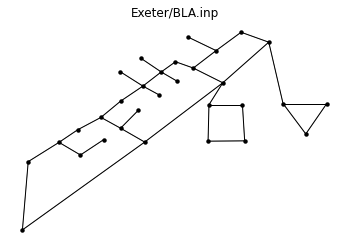

In [17]:
# Create a water network model
inp_file = 'Exeter/BLA.inp'
wn_WDS = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn_WDS, title=wn_WDS.name)

# Simulate hydraulics
# sim_WDS = wntr.sim.EpanetSimulator(wn_WDS)
# results_WDS = sim_WDS.run_sim()

In [18]:
#del database

In [19]:
# Import database: contains information for all the simulations run
try:
    print(database is None)
except:
    database = pickle.load( open( "Datasets/BLA_dataset.p", "rb" ))

In [20]:
database = database['data']

In [21]:
database[0]

Data(ID=[31], base_demand=[31], base_head=[31], diameter=[70], edge_index=[2, 70], elevation=[31], length=[70], pos=[31, 2], res_PP=[1], res_Todini=[1], roughness=[70], type=[70], type_1H=[31])

### Geometric Dataset

Organize and normalize the dataset 

In [22]:
torch.set_default_dtype(torch.float64)

#### Scalers

In [23]:
elev_and_head = torch.cat((database[0].elevation, database[0].base_head))

In [24]:
sc_base_dem  = Scaler(type_norm='Gaussian')
sc_head_elev = Scaler(type_norm='Linear', par1 = min(elev_and_head), par2 =max(elev_and_head) )

sc_diameter  = Scaler(type_norm='Linear', par1 = 0, par2 = 1)
sc_length    = Scaler(type_norm='Gaussian')
sc_roughness = Scaler(type_norm='Linear', par1=80, par2=150)


#### Creating the final graphs
These graphs contain the information in the nodes (x), edges (edge_attr), and the target (res_PP)

In [25]:
graphs = []
for i in database:
    if i.res_PP>0:
        current = Data()
        current.edge_index = i.edge_index
        current.ID =  i.ID
        current.pos = i.pos

        current.x = torch.cat(( i.type_1H.view(-1,1),      #Already normalized
                                sc_base_dem.scale(i.base_demand).view(-1,1),  #
                                sc_head_elev.scale(i.base_head).view(-1,1),
                                sc_head_elev.scale(i.elevation).view(-1,1)), 1).double()

        current.edge_attr = torch.cat(( 
                            sc_diameter.scale(i.diameter).view(-1,1),
                            sc_length.scale(i.length).view(-1,1), 
                            sc_roughness.scale(i.roughness).view(-1,1))
                            , 1).double()

        current.y = i.res_PP

        graphs.append(current)
    

In [26]:
#Example of the normalized weights in the adjacency matrix (as edge index and edge weight)
#graphs[3].weight.t(), graphs[3].edge_index
#graphs[3].diams_n.t(), graphs[3].edge_index

In [27]:
#graphs[3].base_head

In [28]:
len(graphs)

4418

In [29]:
graphs[3].y

tensor([0.1255])

### Data split

In [30]:
# create dataset
#split_ix = 3000
seed = 1135
batch_size = 64
split_ix = int(0.8 * len(graphs))
#val_size = int(0.2 * len(graphs))
train_loader = torch_geometric.data.DataLoader(graphs[:split_ix], batch_size=batch_size, shuffle=True)
valid_loader = torch_geometric.data.DataLoader(graphs[split_ix:], batch_size=batch_size, shuffle=True)

In [31]:
# for step, data in enumerate(train_loader):
#     print(f'Step {step + 1}:')
#     print('=======')
#     print(f'Number of graphs in the current batch: {data.num_graphs}')
#     print(data)
#     print()

In [32]:
#seed = 1135
#train_size = int(0.8 * len(graphs))
#val_size = int(0.1 * len(graphs))
#test_size = len(graphs) -val_size - train_size
#train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(graphs, [train_size, val_size, test_size],generator=torch.Generator().manual_seed(seed))

## **Message Passing**

**MessagePassing(aggr="add", flow="source_to_target", node_dim=-2):** \
Defines the aggregation scheme to use ("add", "mean" or "max") and the flow direction of message passing (either "source_to_target" or "target_to_source"). Furthermore, the node_dim attribute indicates along which axis to propagate.

$${\huge \mathbf{x}_i^{\prime} = \gamma_{\mathbf{\Theta}} \left( \mathbf{x}_i,
\square_{j \in \mathcal{N}(i)} \, \phi_{\mathbf{\Theta}}
\left(\mathbf{x}_i, \mathbf{x}_j,\mathbf{e}_{j,i}\right) \right) }$$ 

where $\square$ denotes a differentiable, permutation invariant function, e.g., sum, mean or max, and $\gamma_{\mathbf{\Theta}}$ and $ \phi_{\mathbf{\Theta}}$ denote differentiable functions such as MLPs.
Source: [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html)

### Layer definition

#### Graph filter

### Model definition

In [47]:
next(iter(train_loader))

Batch(ID=[64], batch=[1984], edge_attr=[4480, 3], edge_index=[2, 4480], pos=[1984, 2], x=[1984, 4], y=[64])

In [57]:
torch.ones(len(graphs[0].x), dtype = torch.int64)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1])

In [178]:
class Net(nn.Module):
    def __init__(self, hid_units, K):
        super(Net, self).__init__()
        self.K = K
        self.hid_units = hid_units
        self.conv1 = G_filter_K(units = [1, self.hid_units], aggr ='add', K = self.K)
        self.conv2 = G_filter_K(units = [self.hid_units, self.hid_units], aggr ='add', K = self.K)
        #self.conv3 = G_filter_K(units = [self.hid_units, self.hid_units], aggr ='add', K = self.K)
        self.fc1 = nn.Linear(self.hid_units,1)
#         self.fc2 = nn.Linear(int(self.hid_units/2),1)

    def forward(self, data, prt=False):
        edge_attr  = data.edge_attr[:,0]
        edge_index = data.edge_index
        #print(data)
        
        try:
            batch = data.batch
        except:
            batch = torch.zeros(len(data.x), dtype = torch.int64)
        
        x = data.x[:,1].view(-1, 1)
        
        x = self.conv1(x, edge_attr, edge_index)
        x = torch.sigmoid(x)

#         x = self.conv2(x, edge_attr, edge_index)
#         x = torch.sigmoid(x)
        
#         x = self.conv3(x, edge_attr, edge_index)
#         x = torch.sigmoid(x)
        
        x = self.fc1(x)
        x = torch.sigmoid(x)
        
        if prt == True:
            print(x)
        
#         x = self.fc2(x)
#         x = torch.sigmoid(x)
        
        x = global_mean_pool(x, batch)
        
        
        return x  #, x
    
    # Calculates the number of parameters for each layer (weights and biases are summed together)
    def N_parameters(self):
        self.num_params = []
#         i = 0
        
        for parameter in self.parameters():
            self.num_params.append(torch.numel(parameter))

        return self.num_params

## Training

### Hyperparameters

In [184]:
#N_epochs = 1000
params = OrderedDict(
    lr = [1e-5]
    ,weight_decay=[0]
    ,N_epochs = [20]
    ,hid_units = [32, 64]
    ,K = [2]
    #,batch_size = [50] #T.B.I
)

report_freq=5

In [185]:
runs = RunBuilder.get_runs(params)

In [186]:
runs

[Run(lr=1e-05, weight_decay=0, N_epochs=20, hid_units=32, K=2),
 Run(lr=1e-05, weight_decay=0, N_epochs=20, hid_units=64, K=2)]

### Forward and Backpropagation

#### Batch training

In [187]:
#len(model(next(iter(train_loader))))

In [188]:
next(iter(train_loader))

Batch(ID=[64], batch=[1984], edge_attr=[4480, 3], edge_index=[2, 4480], pos=[1984, 2], x=[1984, 4], y=[64])

In [189]:
f.description = 'Loading...'
display(f)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for run in RunBuilder.get_runs(params):
    print("-------------------New configuration-------------------")
    model = Net(hid_units = run.hid_units, K=run.K).to(device)
    start_time = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr=run.lr, weight_decay=run.weight_decay)
    f.value = 0
    f.max = run.N_epochs
    model.train()
    for epoch in range(run.N_epochs):
        total_loss= 0
        
        for training_graph in train_loader:
            pred = model(training_graph)#[0]
            target = training_graph.y
            loss = F.mse_loss(pred.view(-1,1), target.view(-1,1))  
            #print(pred, target)
            loss.to(torch.float32)
            total_loss += loss
        
            #total_loss /= len(train_dataset)
            #total_loss = total_loss.to(torch.float32)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        f.value += 1
        f.description = 'Epoch {}/{}'.format(epoch+1,f.max)
        if epoch%report_freq == 0 or epoch == run.N_epochs-1:
            #print(model.conv1.H[0])
            r2 = np.round(graph_r2(model, training_graph), 4)
            print('\t', "epoch ", epoch, '\t'," total loss:  ", np.round(total_loss.item(),4), '\t', 'R2: ', r2)
            
    comment = f'-{run}'
    execution_time=np.round((time.time() - start_time), 2)
    print(comment, execution_time, 'seconds')
    print('Total parameters:','\t', np.array(model.N_parameters()).sum(), "\n")
    
winsound.Beep(1000, 100) #Ending sound


IntProgress(value=20, description='Loading...', max=20)

-------------------New configuration-------------------


C:\Programs\Anaconda3\envs\PyTorch_Env\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


	 epoch  0 	  total loss:   3.9513 	 R2:  -53.4374
	 epoch  5 	  total loss:   3.6387 	 R2:  -59.0581
	 epoch  10 	  total loss:   3.3229 	 R2:  -32.9053
	 epoch  15 	  total loss:   3.0469 	 R2:  -42.1422
	 epoch  19 	  total loss:   2.8445 	 R2:  -17.8989
-Run(lr=1e-05, weight_decay=0, N_epochs=20, hid_units=32, K=2) 16.8 seconds
Total parameters: 	 3201 

-------------------New configuration-------------------


C:\Programs\Anaconda3\envs\PyTorch_Env\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


	 epoch  0 	  total loss:   4.5256 	 R2:  -52.0904
	 epoch  5 	  total loss:   3.8566 	 R2:  -63.9496
	 epoch  10 	  total loss:   3.2841 	 R2:  -24.2461
	 epoch  15 	  total loss:   2.781 	 R2:  -39.2413
	 epoch  19 	  total loss:   2.4333 	 R2:  -19.8991
-Run(lr=1e-05, weight_decay=0, N_epochs=20, hid_units=64, K=2) 16.96 seconds
Total parameters: 	 12545 



In [190]:
model(graphs[0], prt = True) #, graphs[0].y

tensor([[0.3383],
        [0.4015],
        [0.3210],
        [0.3133],
        [0.3556],
        [0.4034],
        [0.4377],
        [0.3624],
        [0.3177],
        [0.3319],
        [0.3988],
        [0.3459],
        [0.3995],
        [0.3477],
        [0.3682],
        [0.3616],
        [0.3135],
        [0.4169],
        [0.4018],
        [0.3220],
        [0.3307],
        [0.3264],
        [0.3204],
        [0.4173],
        [0.3476],
        [0.3223],
        [0.3606],
        [0.3349],
        [0.3802],
        [0.3296],
        [0.3085]], grad_fn=<SigmoidBackward>)


tensor([[0.3560]], grad_fn=<DivBackward0>)

In [192]:
graphs[0].y

tensor([0.1612])

In [193]:
for i in range(10):
    print(model(graphs[i]))

tensor([[0.3560]], grad_fn=<DivBackward0>)
tensor([[0.3566]], grad_fn=<DivBackward0>)
tensor([[0.3572]], grad_fn=<DivBackward0>)
tensor([[0.3581]], grad_fn=<DivBackward0>)
tensor([[0.3563]], grad_fn=<DivBackward0>)
tensor([[0.3574]], grad_fn=<DivBackward0>)
tensor([[0.3570]], grad_fn=<DivBackward0>)
tensor([[0.3564]], grad_fn=<DivBackward0>)
tensor([[0.3573]], grad_fn=<DivBackward0>)
tensor([[0.3577]], grad_fn=<DivBackward0>)


In [232]:
a, b = model(graphs[-1])[0], model(graphs[-1])[1].detach().numpy()

In [233]:
a

tensor(0.6622, grad_fn=<MeanBackward0>)

In [183]:
for i in b:
    print(i[0])

0.7371584
0.57573164
0.88126034
0.5991537
0.8161363
0.5977639
0.6336391
0.5693125
0.70629174
0.702073
0.62919104
0.64857864
0.84823895
0.74637103
0.6388566
0.5704113
0.76099145
0.51795447
0.83995485
0.0025988976
0.8848422


In [186]:
for i in wn_WDS.node_name_list:
    print(i)

20
30
40
50
55
60
70
75
80
90
100
110
115
120
130
140
150
160
170
65
165


In [194]:
a = database.iloc[-1].wntrModel

In [224]:
b = a.get_links_for_node('65')

In [225]:
wntr.epanet.io.InpFile.write('trial_local.inp', a)

TypeError: write() missing 1 required positional argument: 'wn'

In [226]:
for i in a.pipes():
    print(i)

('2', <Pipe '2' from '20' to '70', length=3657.6000000000004, diameter=0.30479999999999996, roughness=70.0, minor_loss=0.0, check_valve=False, status=Open>)
('4', <Pipe '4' from '20' to '30', length=3657.6000000000004, diameter=0.35559999999999997, roughness=120.0, minor_loss=0.0, check_valve=False, status=Open>)
('6', <Pipe '6' from '20' to '110', length=3657.6000000000004, diameter=0.15239999999999998, roughness=70.0, minor_loss=0.0, check_valve=False, status=Open>)
('8', <Pipe '8' from '70' to '30', length=2743.2000000000003, diameter=0.2032, roughness=70.0, minor_loss=0.0, check_valve=False, status=Open>)
('10', <Pipe '10' from '70' to '100', length=182.88, diameter=0.2032, roughness=70.0, minor_loss=0.0, check_valve=False, status=Open>)
('12', <Pipe '12' from '70' to '90', length=182.88, diameter=0.35559999999999997, roughness=70.0, minor_loss=0.0, check_valve=False, status=Open>)
('14', <Pipe '14' from '70' to '60', length=182.88, diameter=0.254, roughness=70.0, minor_loss=0.0, c

In [228]:
b

['78']

In [231]:
c=np.array([0.15239])
rescale(c, minT=0, maxT=20)#*0.254

array([3.048])

#### Joblib implementation - Update: Failed, it's slower

In [207]:
# def fun(training_graph):
#     pred = model(training_graph).mean()
#     target = training_graph.y
#     loss = F.mse_loss(pred.reshape(-1,1), target.reshape(-1,1))            
#     #loss.to(torch.float32)
    
#     return loss

In [220]:
# for run in RunBuilder.get_runs(params):
#     display(f)
#     start_time = time.time()
#     optimizer = torch.optim.Adam(model.parameters(), lr=run.lr, weight_decay=run.weight_decay)
#     f.value = 0
#     f.max = run.N_epochs
#     model.train()
#     for epoch in range(run.N_epochs):
#         total_loss= 0
#         losses = Parallel(n_jobs=-1)(delayed(fun)(training_graph) for training_graph in train_dataset)
#         total_loss = torch.tensor(losses, requires_grad=True).mean()
#         #total_loss.requires_grad = True
#         #print(total_loss)
#         #total_loss /= len(train_dataset)
#         #total_loss = total_loss.to(torch.float32)
#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()
        
#         f.value += 1
#         if epoch%10 == 0:
#             print("epoch ", epoch, " total loss  ", total_loss )
# #             clear_output(wait=True)
# #             display(f)
            
#     comment = f'-{run}'
#     execution_time=np.round((time.time() - start_time),2)
#     print(comment, execution_time, 'seconds')

IntProgress(value=51, description='Loading:', max=51)

epoch  0  total loss   tensor(0.1603, grad_fn=<MeanBackward0>)
epoch  10  total loss   tensor(0.1563, grad_fn=<MeanBackward0>)
epoch  20  total loss   tensor(0.1522, grad_fn=<MeanBackward0>)
epoch  30  total loss   tensor(0.1482, grad_fn=<MeanBackward0>)
epoch  40  total loss   tensor(0.1443, grad_fn=<MeanBackward0>)
epoch  50  total loss   tensor(0.1404, grad_fn=<MeanBackward0>)
-Run(lr=0.001, weight_decay=0.0005, N_epochs=51) 206.75 seconds


## Testing
*To be further implemented

In [34]:
print('Training R2: \t', np.round(graph_r2(model, train_dataset), 4))
print('Validation R2: \t', np.round(graph_r2(model, val_dataset), 4))

Training R2: 	 0.57
Validation R2: 	 0.5604


In [35]:
#Simple test
print('Actual \t',  'Pred')
for i in range(10):
    print(np.round(rescale(graphs[i].y.item(),-1,1),4), '\t', np.round(rescale(model(graphs[i]).item(), -1,1),4) )

Actual 	 Pred
0.3997 	 0.3106
0.4345 	 0.3918
0.4562 	 0.4173
0.3883 	 0.3733
0.4384 	 0.4189
0.3341 	 0.3261
0.476 	 0.475
0.2792 	 0.2975
0.4296 	 0.3763
0.3782 	 0.3918


In [36]:
preds_train, y_train = res_and_tar(model,train_dataset)
preds_val, y_val = res_and_tar(model,val_dataset)

In [37]:
x_real_values_train = rescale(y_train, minT = -1, maxT=1)
y_pred_values_train = rescale(preds_train, minT = -1, maxT=1)

x_real_values_test = rescale(y_val, minT=-1, maxT=1)
y_pred_values_test = rescale(preds_val, minT=-1, maxT=1)

In [38]:
fig = pred_vs_y_plotly(x_real_values_train, y_pred_values_train, x_real_values_test, y_pred_values_test)
fig

FigureWidget({
    'data': [{'line': {'dash': 'dash'},
              'marker': {'size': 3},
              'mod…